# Building a Throw-In Classifier Using Transfer Learning
Trying to identify clips of throw-ins from Bundesliga games. This transfer learning model will be built with fastai and this notebook will build and train that model.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import imageio.v3 as iio 
import cv2
import os

from fastai.data.all import *
from fastai.vision.all import *

from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip
from IPython.display import Video
from tqdm.notebook import tqdm

In [3]:
data_path = Path('data/')
train_df = pd.read_csv(data_path/'train.csv')
train_df.head()

,video_id,time,event,event_attributes
0,1606b0e6_0,200.265822,start,NaN
1,1606b0e6_0,201.150000,challenge,['ball_action_forced']
2,1606b0e6_0,202.765822,end,NaN
3,1606b0e6_0,210.124111,start,NaN
4,1606b0e6_0,210.870000,challenge,['opponent_dispossessed']


In [4]:
df_throwin = train_df[train_df['event'] == 'throwin'].copy()

In [5]:
def vis_event(row, before=5, after=5):
    print(row["event_attributes"])
    filename = f"train_{row.name}.mp4"
    ffmpeg_extract_subclip(
        f'data/train/{row["video_id"]}.mp4',
        #f"../input/dfl-bundesliga-data-shootout/train/{row['video_id']}.mp4", 
        row['time'] - before, 
        row['time'] + after, 
        targetname=filename
    )
    
    return Video(filename, width=800)

In [6]:
r = df_throwin.iloc[0]
vis_event(r,0.35,0.35)

['pass']
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful


In [7]:
def get_image(vid_id, frame, ind):
    video_file = data_path/'train'/vid_id
    p = data_path/vid_id/ind
    if not os.path.exists(p):
        os.makedirs(p)
    if not os.path.exists(p/f'/{frame}.png'):
        image = iio.imread(f'{video_file}.mp4', index=frame)
        iio.imwrite(p/f'{frame}.png', image)

In [8]:
# fps = 25
# fnames = []
# for i, row in tqdm(df_throwin.iterrows(), total=len(df_throwin)):
#     vid_id = row['video_id']
#     t1 = row['time'] - 0.15
#     t2 = row['time'] + 0.15
#     frame_start = int(t1 * fps)
#     frame_end = int(t2 * fps)

#     video_file = data_path/'train'/vid_id
#     p = data_path/vid_id/f'{i}'
#     if not os.path.exists(p):
#         os.makedirs(p)
#     for j in range(frame_start, frame_end + 1):
#         if not os.path.exists(p/f'/{j}.png'):
#             image = iio.imread(f'{video_file}.mp4', index=j)
#             iio.imwrite(p/f'{j}.png', image)
#     fnames.append(p)
#     #try:
#     #    fps = train_meta[vid_id]
#     #except KeyError:
#     #    video = cv2.VideoCapture(f'{video_file}.mp4')
#     #    fps = video.get(cv2.CAP_PROP_FPS)
#     #    train_meta[vid_id] = fps
# df_throwin['fname'] = fnames

In [9]:
fps = 25
def get_images(vid_id, time, ind):
    t1 = time - 0.15
    t2 = time + 0.15
    frame_start = int(t1 * fps)
    frame_end = int(t2 * fps)

    video_file = data_path/'train'/vid_id
    p = data_path/vid_id/f'{ind}'
    if not os.path.exists(p):
        os.makedirs(p)
    for j in range(frame_start, frame_end + 1):
        if not os.path.exists(p/f'{j}.png'):
            try:
                image = iio.imread(f'{video_file}.mp4', index=j)
                iio.imwrite(p/f'{j}.png', image)
            except IndexError:
                print(j, p)
                p = None
    return p

In [10]:
fnames = [get_images(v, t, i) for v, t, i in tqdm(zip(df_throwin['video_id'], df_throwin['time'], df_throwin.index.values), total=len(df_throwin))]
df_throwin['fnames'] = fnames

  0%|          | 0/172 [00:00<?, ?it/s]

In [13]:
# making a negative dataset the size of the positive one
scale = 1

pos_set = df_throwin['time'].astype(int)
neg_set = []
while len(neg_set) < len(df_throwin) * scale:
    tmp = random.randint(0,(12*60)-1)
    if tmp not in neg_set and tmp not in pos_set:
        neg_set.append(tmp)

vid_paths = data_path/'train'
vid_paths = vid_paths.ls()
neg_paths = []
index = -1
for t in tqdm(neg_set):
    i = random.randint(0,len(vid_paths)-1)
    neg_paths.append(get_images(vid_paths[i].stem, t, index))
    index += -1

  0%|          | 0/172 [00:00<?, ?it/s]

In [11]:
# all_paths = []
# for a in data_path.ls():
#     if '.' not in str(a):
#         all_paths += a.ls()
# neg_paths = []
# for a in all_paths:
#     if '-' in str(a):
#         neg_paths.append(a)

neg_paths = []
for a in data_path.ls():
    if '.' not in str(a):
        for b in a.ls():
            if '-' in str(b):
                neg_paths.append(b)
neg_paths[0:3]

[Path('data/1606b0e6_0/-102'),
 Path('data/1606b0e6_0/-112'),
 Path('data/1606b0e6_0/-137')]

In [12]:
df_train = pd.DataFrame(df_throwin.fnames.copy())
df_train['label'] = ['throwin'] * len(df_throwin)
len(df_train)
df_neg = pd.DataFrame({'fnames': neg_paths, 'label': ['no_throwin'] * len(neg_paths)})
df_train = pd.concat([df_train, df_neg])

In [13]:
p = data_path/'train'
p.ls()[0].stem

'1606b0e6_0'

In [14]:
class ImageTuple(fastuple):
    "A tuple of PILImages"
    def show(self, ctx=None, **kwargs): 
        n = len(self)
        img0, img1, img2= self[0], self[n//2], self[n-1]
        if not isinstance(img1, Tensor):
            t0, t1,t2 = tensor(img0), tensor(img1),tensor(img2)
            t0, t1,t2 = t0.permute(2,0,1), t1.permute(2,0,1),t2.permute(2,0,1)
        else: t0, t1,t2 = img0, img1,img2
        return show_image(torch.cat([t0,t1,t2], dim=2), ctx=ctx, **kwargs)

In [15]:
class ImageTupleTfm(Transform):
    "A wrapper to hold the data on path format"
    def __init__(self, seq_len=20):
        store_attr()
        
    def encodes(self, path: Path):
        "Get a list of images files for folder path"
        frames = path.ls_sorted()
        n_frames = len(frames)
        s = slice(0, min(self.seq_len, n_frames))
        return ImageTuple(tuple(PILImage.create(f) for f in frames[s]))

In [16]:
instances_path = list(df_train['fnames'])
instances_path[0:3]

#tfm = ImageTupleTfm(seq_len=5)

[Path('data/1606b0e6_0/7'),
 Path('data/1606b0e6_0/101'),
 Path('data/1606b0e6_0/119')]

In [17]:
@patch
def ls_sorted(self:Path):
    "ls but sorts files by name numerically"
    return self.ls().sorted(key=lambda f: int(f.with_suffix('').name))

In [18]:
instances_path[0].ls_sorted()

(#8) [Path('data/1606b0e6_0/7/5477.png'),Path('data/1606b0e6_0/7/5478.png'),Path('data/1606b0e6_0/7/5479.png'),Path('data/1606b0e6_0/7/5480.png'),Path('data/1606b0e6_0/7/5481.png'),Path('data/1606b0e6_0/7/5482.png'),Path('data/1606b0e6_0/7/5483.png'),Path('data/1606b0e6_0/7/5484.png')]

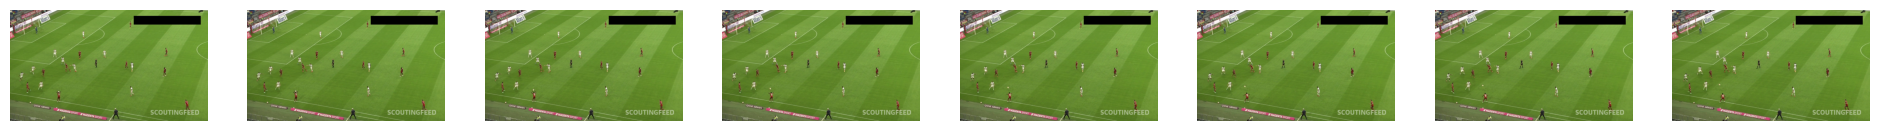

In [19]:
frames = instances_path[0].ls_sorted()
show_images([Image.open(img) for img in frames])

<AxesSubplot:>

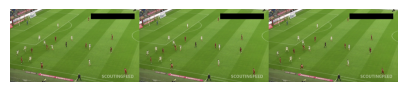

In [19]:
ImageTuple(PILImage.create(fn) for fn in frames).show()

In [20]:
tfm = ImageTupleTfm(seq_len=8)
tmp = instances_path[0]
tmp

Path('data/1606b0e6_0/7')

<AxesSubplot:>

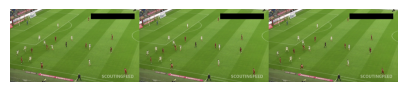

In [21]:
tfm(tmp).show()

In [22]:
def labeller(path):
    if path in neg_paths:
        return 'no_throwin'
    else:
        return 'throwin'
labeller(instances_path[0])

'throwin'

In [23]:
splits = RandomSplitter()(instances_path)

In [24]:
ds = Datasets(instances_path,
            tfms=[[ImageTupleTfm(8)], [labeller, Categorize()]],
            splits=splits)

In [25]:
len(ds)

348

In [26]:
dls = ds.dataloaders(bs=4, after_item=[Resize(128), ToTensor], 
                      after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)])

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


In [21]:
def get_action_dataloaders(files, bs=8, image_size=64, seq_len=20, val_idxs=None, **kwargs):
    "Create a dataloader with `val_idxs` splits"
    splits = RandomSplitter()(files) if val_idxs is None else IndexSplitter(val_idxs)(files)
    itfm = ImageTupleTfm(seq_len=seq_len)
    ds = Datasets(files, tfms=[[itfm], [parent_label, Categorize]], splits=splits)
    dls = ds.dataloaders(bs=bs, after_item=[Resize(image_size), ToTensor], 
                         after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)], drop_last=True, **kwargs)
    return dls

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


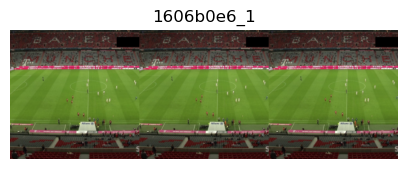

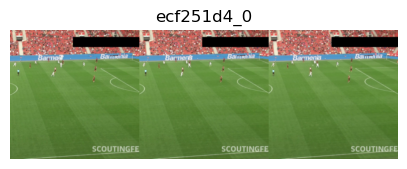

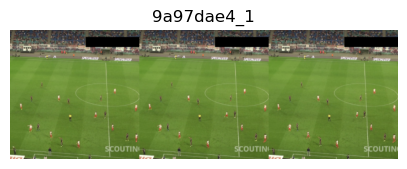

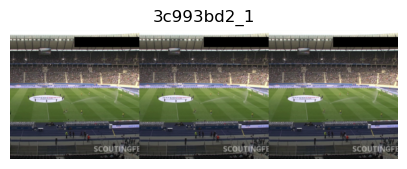

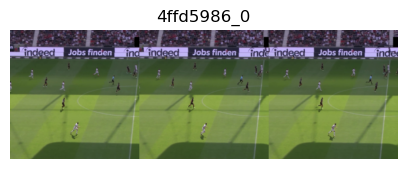

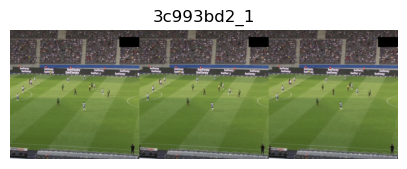

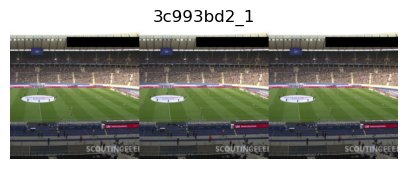

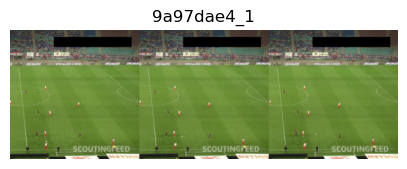

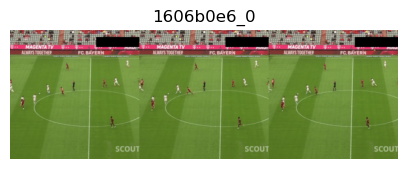

In [22]:
dls = get_action_dataloaders(instances_path, bs=32, image_size=128, seq_len=8)
dls.show_batch()

In [23]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True


## Experimenting with simple models

In [83]:
class SimpleModel(Module):
    def __init__(self, arch=resnet34(), n_out=101):
        self.encoder = TimeDistributed(create_body(arch, pretrained=True))
        self.head = TimeDistributed(create_head(512, 101))
    def forward(self, x):
        x = torch.stack(x, dim=1)
        return self.head(self.encoder(x)).mean(dim=1)
    
def simple_splitter(model): return [params(model.encoder), params(model.head)]

In [24]:
x,y = dls.one_batch()

In [32]:
model = SimpleModel().cuda()

In [72]:
print(f'{type(x) = },\n{len(x) = } ,\n{x[0].shape = }, \n{model(x).shape = }')

type(x) = <class '__main__.ImageTuple'>,
len(x) = 8 ,
x[0].shape = torch.Size([32, 3, 64, 64]), 
encoder(x[0]).shape = torch.Size([32, 512])


In [ ]:
dls.loss_func

In [ ]:
learn = Learner(dls, model, metrics=[error_rate, F1Score()], splitter=simple_splitter).to_fp16()
learn.lr_find()

In [ ]:
learn.fine_tune(3, 1e-3, freeze_epochs=3)

In [30]:
arch = resnet34()
encoder = nn.Sequential(create_body(arch, pretrained=True), nn.AdaptiveAvgPool2d(1), Flatten()).cuda()

In [33]:
encoder(x[0]).shape

torch.Size([16, 512])

In [34]:
tencoder = TimeDistributed(encoder)
tencoder(torch.stack(x, dim=1)).shape

torch.Size([16, 8, 512])

## Making RNN Model

In [25]:
class RNNModel(Module):
    def __init__(self, arch=resnet34(), n_out=101, num_rnn_layers=1):
        self.encoder = TimeDistributed(nn.Sequential(create_body(arch, pretrained=True), nn.AdaptiveAvgPool2d(1), Flatten()))
        self.rnn = nn.LSTM(512, 512, num_layers=num_rnn_layers, batch_first=True)
        self.head = LinBnDrop(num_rnn_layers*512, n_out)
    def forward(self, x):
        x = torch.stack(x, dim=1)
        x = self.encoder(x)
        bs = x.shape[0]
        _, (h, _) = self.rnn(x)
        return self.head(h.view(bs,-1))

In [26]:
def rnnmodel_splitter(model):
    return [params(model.encoder), params(model.rnn)+params(model.head)]

In [27]:
model2 = RNNModel().cuda()

In [28]:
learn = Learner(dls, model2, metrics=[error_rate, F1Score(average='micro')], splitter=rnnmodel_splitter).to_fp16()

SuggestedLRs(valley=0.00015848931798245758)

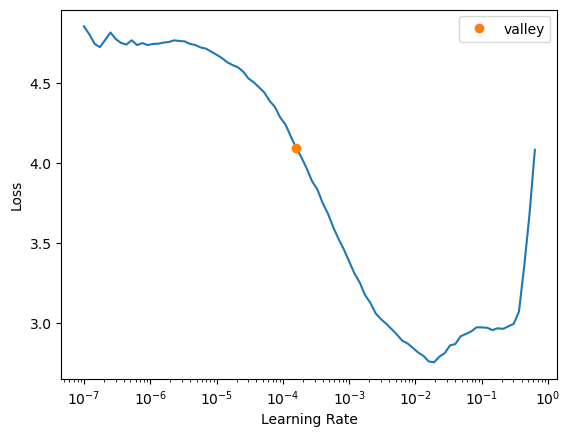

In [39]:
learn.lr_find()

In [31]:
learn.fine_tune(5, 1e-3)

epoch,train_loss,valid_loss,error_rate,f1_score,time
0,4.142944,4.540998,0.913043,0.086957,03:56


epoch,train_loss,valid_loss,error_rate,f1_score,time


KeyboardInterrupt: 

In [30]:
learn.show_results()

KeyboardInterrupt: 